In [20]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT
from dstft.loss import kurtosis_loss, entropy_loss
from dstft.optim import scale_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


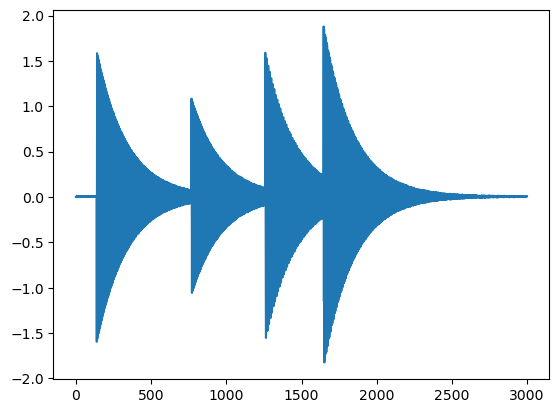

In [2]:
fs = 1e3
t = torch.arange(0, 3, 1/fs)
L = t.shape[0]
#index_impulse = torch.randint(0, L, size = (5,))
mark_list = [138, 768, 1259, 1647]
index_impulse = torch.tensor(mark_list).long()

alpha = 5
f =  torch.ones_like(t)
f[:768] = 250 * f[:768]
f[768:1259] = 200 * f[768:1259]
f[1259:1647] = 100 * f[1259:1647]
f[1647:] = 300 * f[1647:]
x =  torch.sin(torch.cumsum(2*pi*f, dim=0)/fs) 
y = torch.zeros_like(x)
y[index_impulse] = 1 + torch.rand(index_impulse.shape)
z = torch.exp(-t*alpha)
z1 = torch.fft.ifft(torch.fft.fft(z)*torch.fft.fft(y))
x = x * z1.real + .01 * torch.rand(f.shape)
x = x[None, :].to(device)
plt.plot(x[0].cpu())


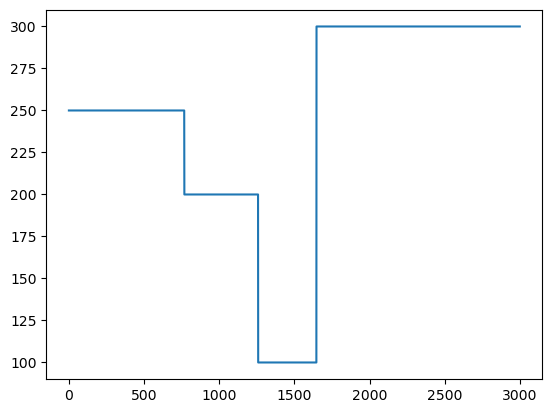

In [29]:
plt.figure()
plt.plot(f)
plt.show()

In [3]:
device

'cuda'

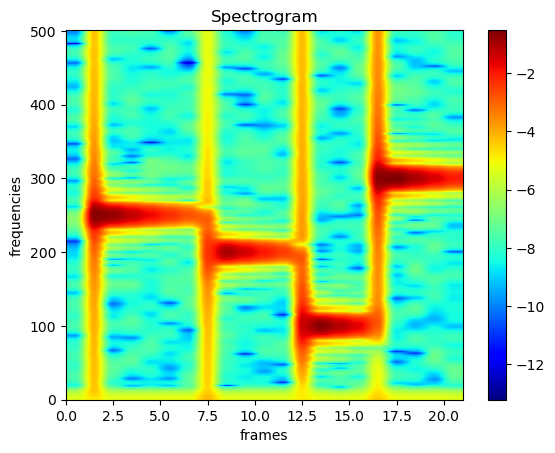

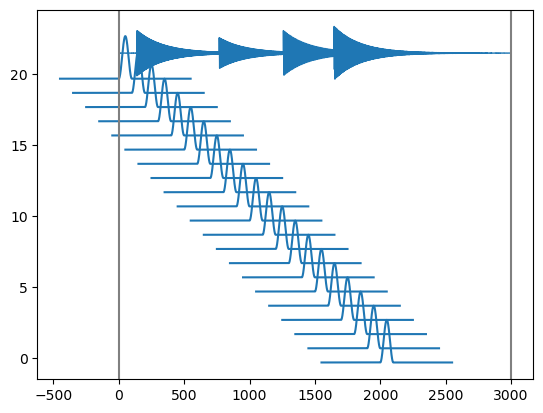

In [4]:
dstft = DSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p='tf', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True)

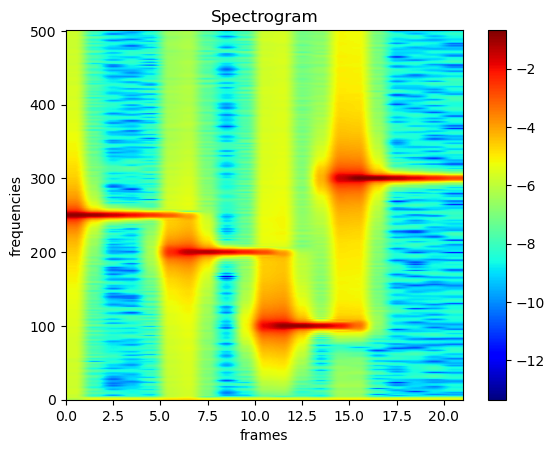

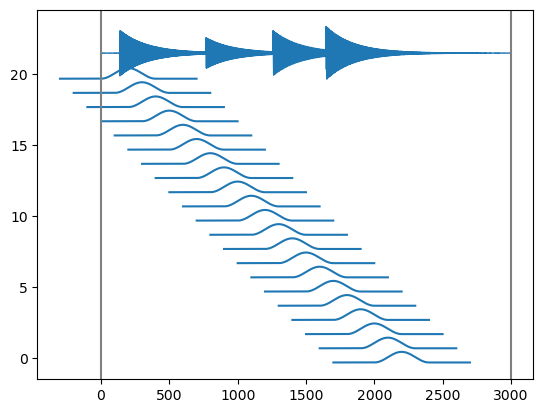

In [28]:
dstft = DSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p='tf', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True)

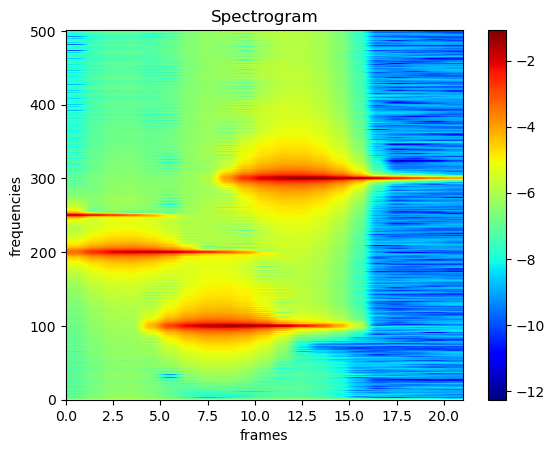

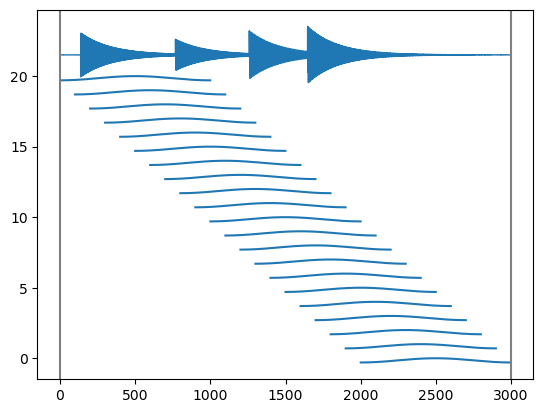

In [13]:
dstft = DSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p='tf', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True)

time-varying hop length

0 13.645
100 11.783
200 11.309
300 10.856
400 10.774
500 10.761
600 10.757
700 10.755
800 10.754
Epoch 00815: reducing learning rate of group 0 to 1.0000e-01.
900 10.754
Epoch 00915: reducing learning rate of group 0 to 1.0000e-02.
914


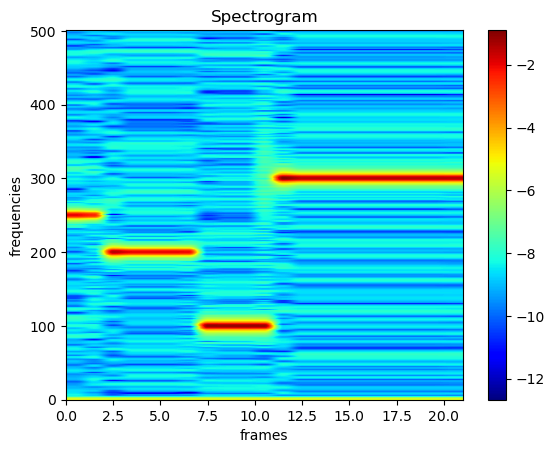

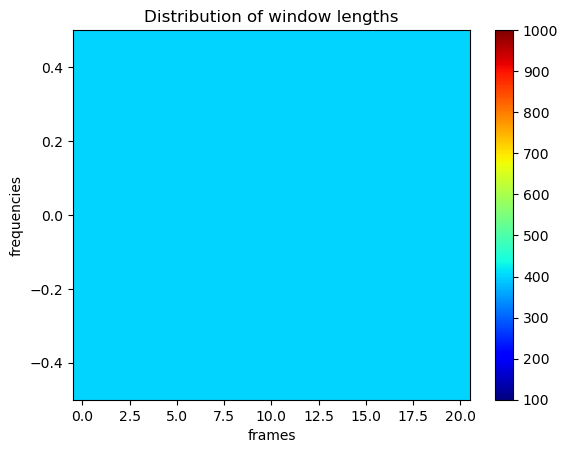

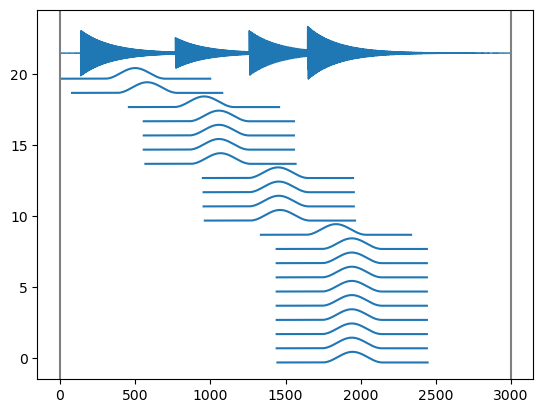

In [22]:
dstft = DSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 ==0:
        print(f'{epoch} {err:.3f}')
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

True
0 10.754
100 10.749
200 10.747
Epoch 00220: reducing learning rate of group 0 to 1.0000e-01.
300 10.747
Epoch 00320: reducing learning rate of group 0 to 1.0000e-02.
319
Parameter containing:
tensor([[400., 400., 400., 400., 400., 400., 400., 400., 400., 400., 400., 400.,
         400., 400., 400., 400., 400., 400., 400., 400., 400.]],
       device='cuda:0')


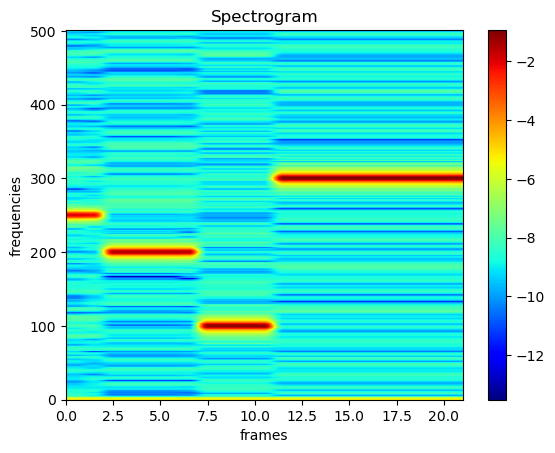

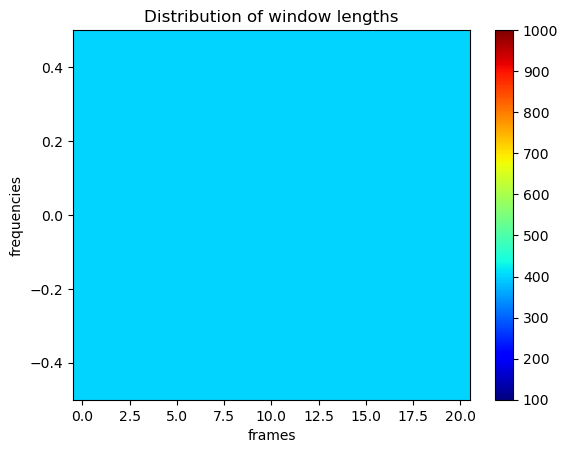

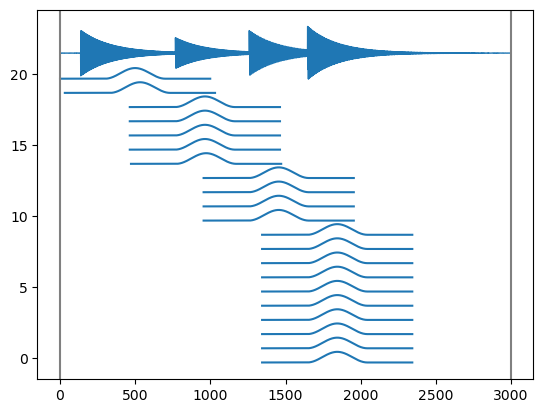

In [23]:
#dstft = DSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
dstft.win_requires_grad = True
dstft.stride_requires_grad = False

print(dstft.win_requires_grad)

params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 ==0:
        print(f'{epoch} {err:.3f}')
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
print(dstft.win_length)
dstft.print(spec, x, bar=True)

True False
True False
0 5.636
100 5.636
Epoch 00101: reducing learning rate of group 0 to 1.0000e+00.
200 5.636
Epoch 00201: reducing learning rate of group 0 to 1.0000e-01.
300 5.636
Epoch 00301: reducing learning rate of group 0 to 1.0000e-02.
400 5.636
Epoch 00401: reducing learning rate of group 0 to 1.0000e-03.
400
Parameter containing:
tensor([[564.9708, 496.1453, 414.4250, 414.4249, 414.4250, 414.4249, 431.3027,
         398.2733, 398.2733, 398.2733, 398.2733, 410.1259, 410.1259, 410.1259,
         410.1259, 410.1259, 410.1259, 410.1259, 410.1259, 410.1259, 410.1259]],
       device='cuda:0', requires_grad=True)


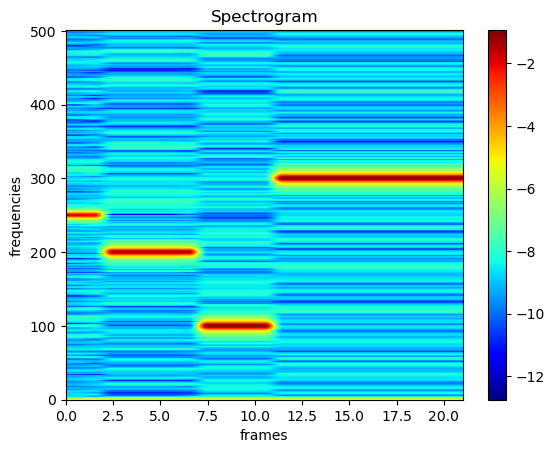

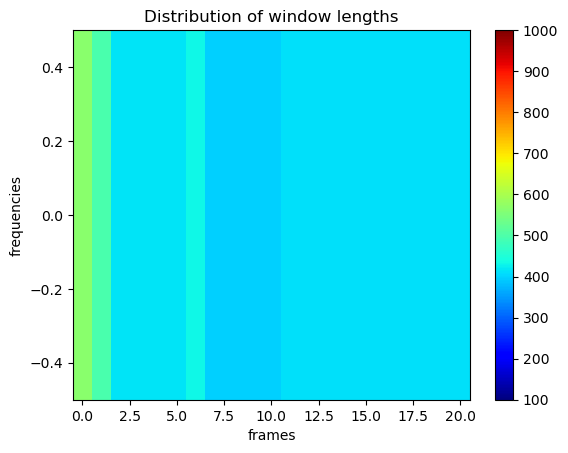

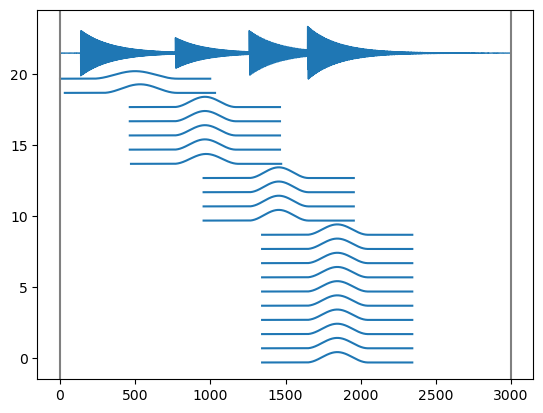

In [27]:
dstft2 = dstft

print(dstft2.win_length.requires_grad, dstft2.strides.requires_grad)
dstft2.win_length.requires_grad = True; dstft2.strides.requires_grad = False
print(dstft2.win_length.requires_grad, dstft2.strides.requires_grad)

params = [{'params': dstft2.parameters(),   'lr': 10.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft2(x)
    err = entropy_loss(spec) #   entropy_loss(spec)   # kurtosis_loss(spec).mean()
    
    if epoch % 100 ==0:
        print(f'{epoch} {err:.3f}')

    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .01:
        break
    
print(epoch)
print(dstft2.win_length)
dstft2.print(spec, x, bar=True)

Multi objective optimization

0 199.819 18.762 200.000
10 130.668 17.914 133.696
20 59.115 17.840 67.181
30 14.744 15.740 3.741
40 15.979 16.742 5.584
50 15.499 16.676 7.299
60 13.760 15.178 8.583
70 12.280 13.595 9.341
80 11.852 13.096 9.841
90 11.705 12.819 10.011
100 11.547 12.520 10.163
110 11.492 12.229 10.548
120 11.415 11.970 10.751
130 11.442 11.750 11.103
Epoch 00132: reducing learning rate of group 0 to 5.0000e-01.
131


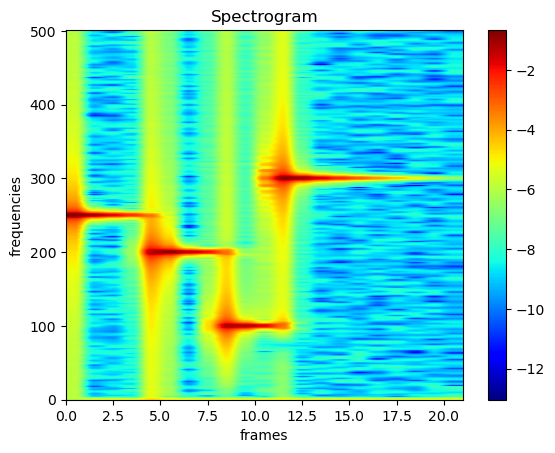

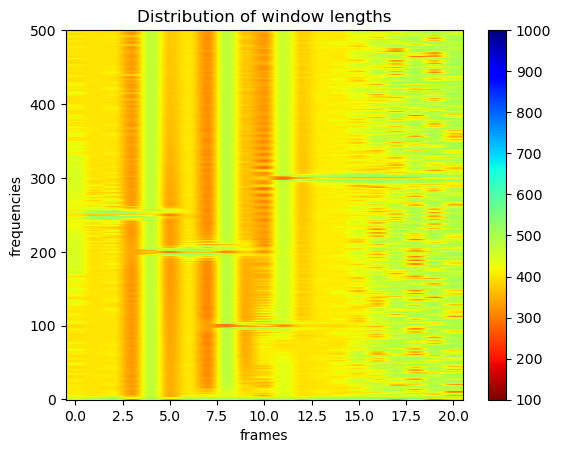

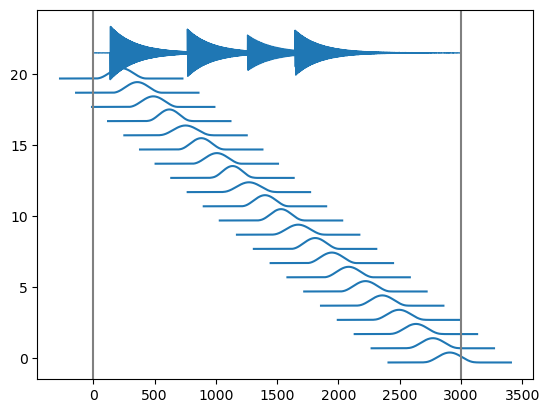

In [8]:
dstft = DSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=10, first_frame=True)
params = [ {'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

def loss_kur(spec, dstft):
    return 1_000 * (1 / kurtosis_loss(spec)).mean()

def loss_cov(dstft):
    return 1_000 * (1 - dstft.coverage())

for epoch in range(10_000):
    scale = scale_loss(dstft, x, loss_kur, loss_cov)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = loss_kur(spec, dstft)
    loss2 = loss_cov(dstft)
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(loss1+loss2)
    
    if epoch % 10 ==0:
        print(f'{epoch} {err:.3f} {loss1:.3f} {loss2:.3f}')
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True)